# K-nearest neighbors: wine quality classification

## Notebook set-up

In [3]:
# Standard library imports
import os
from itertools import combinations
from pathlib import Path

# Core data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Custom helper functions for visualization and analysis
import functions as funcs

# Configuration constants for reproducible results
RANDOM_SEED = 315
CLASS_WEIGHT = 'balanced'
CROSS_VAL_FOLDS = 7

## 1. Data loading
### 1.1. Load data from URL

In [4]:
# URL to the wine quality dataset from the project tutorial repository
url = 'https://raw.githubusercontent.com/rosinni/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv'

# Load the CSV data directly from URL
data_df = pd.read_csv(url, sep=';')

### 1.2. Save a local copy

In [5]:

# Create directory structure for raw data storage
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data in Parquet format for efficient storage
data_df.to_parquet('../data/raw/wine.parquet')

### 1.3. Inspect

Now that we've loaded the data, let's examine its structure and content to understand what we're working with. This initial inspection will help us identify the features, data types, and any potential data quality issues.

In [6]:
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## 2. EDA

### 2.1. Data composition

#### 2.1.1. Label frequencies

Let's examine the distribution of quality ratings in our dataset. This will help us understand if we have a balanced dataset or if certain quality levels are more represented than others.

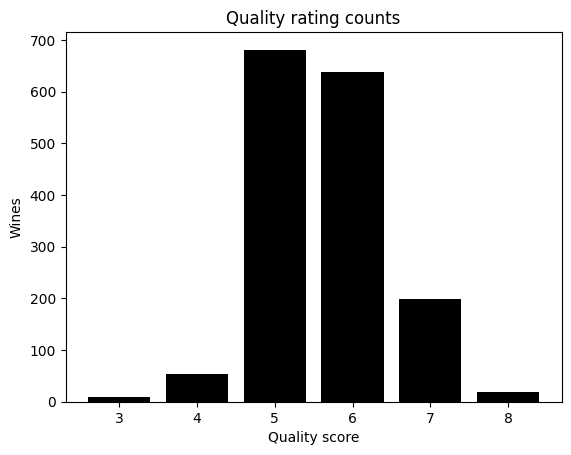

In [8]:
# Count the frequency of each quality rating
quality_counts = data_df['quality'].value_counts()

# Create a bar plot to visualize the distribution of quality ratings
plt.title('Quality rating counts')
plt.bar(quality_counts.index, quality_counts.values, color='black')
plt.xlabel('Quality score')
plt.ylabel('Wines')
plt.show()

#### 2.1.2. Feature distributions

Understanding the distribution of each feature is crucial for our analysis. These histograms will show us the shape of each feature's distribution and help identify potential outliers or skewness that might affect our KNN model.

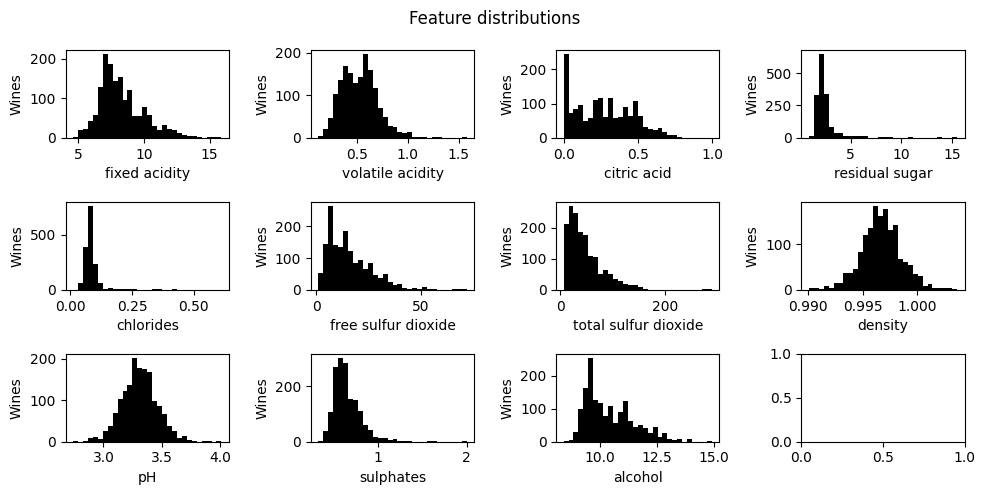

In [9]:
# Define the list of feature columns for analysis
features = ['fixed acidity','volatile acidity','citric acid',
            'residual sugar','chlorides','free sulfur dioxide',
            'total sulfur dioxide','density','pH','sulphates','alcohol']

# Create subplot grid for feature histograms (3 rows, 4 columns to fit 11 features)
fig, axs = plt.subplots(3,4, figsize=(10,5))

# Flatten the 2D array to make indexing easier
axs = axs.flatten()

# Set overall title for the figure
fig.suptitle('Feature distributions')

# Plot histogram for each feature to show its distribution
for i, feature in enumerate(features):
    
    # Create histogram with 30 bins for good resolution
    axs[i].hist(data_df[feature], color='black', bins=30)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Wines')

# Adjust layout to prevent text overlapping between subplots
fig.tight_layout()

### 2.2. Feature interactions

#### 2.2.1. Feature cross-correlations

Examining relationships between features helps us understand potential multicollinearity and feature interactions. These scatter plots will reveal any strong correlations that might impact our KNN model's performance.

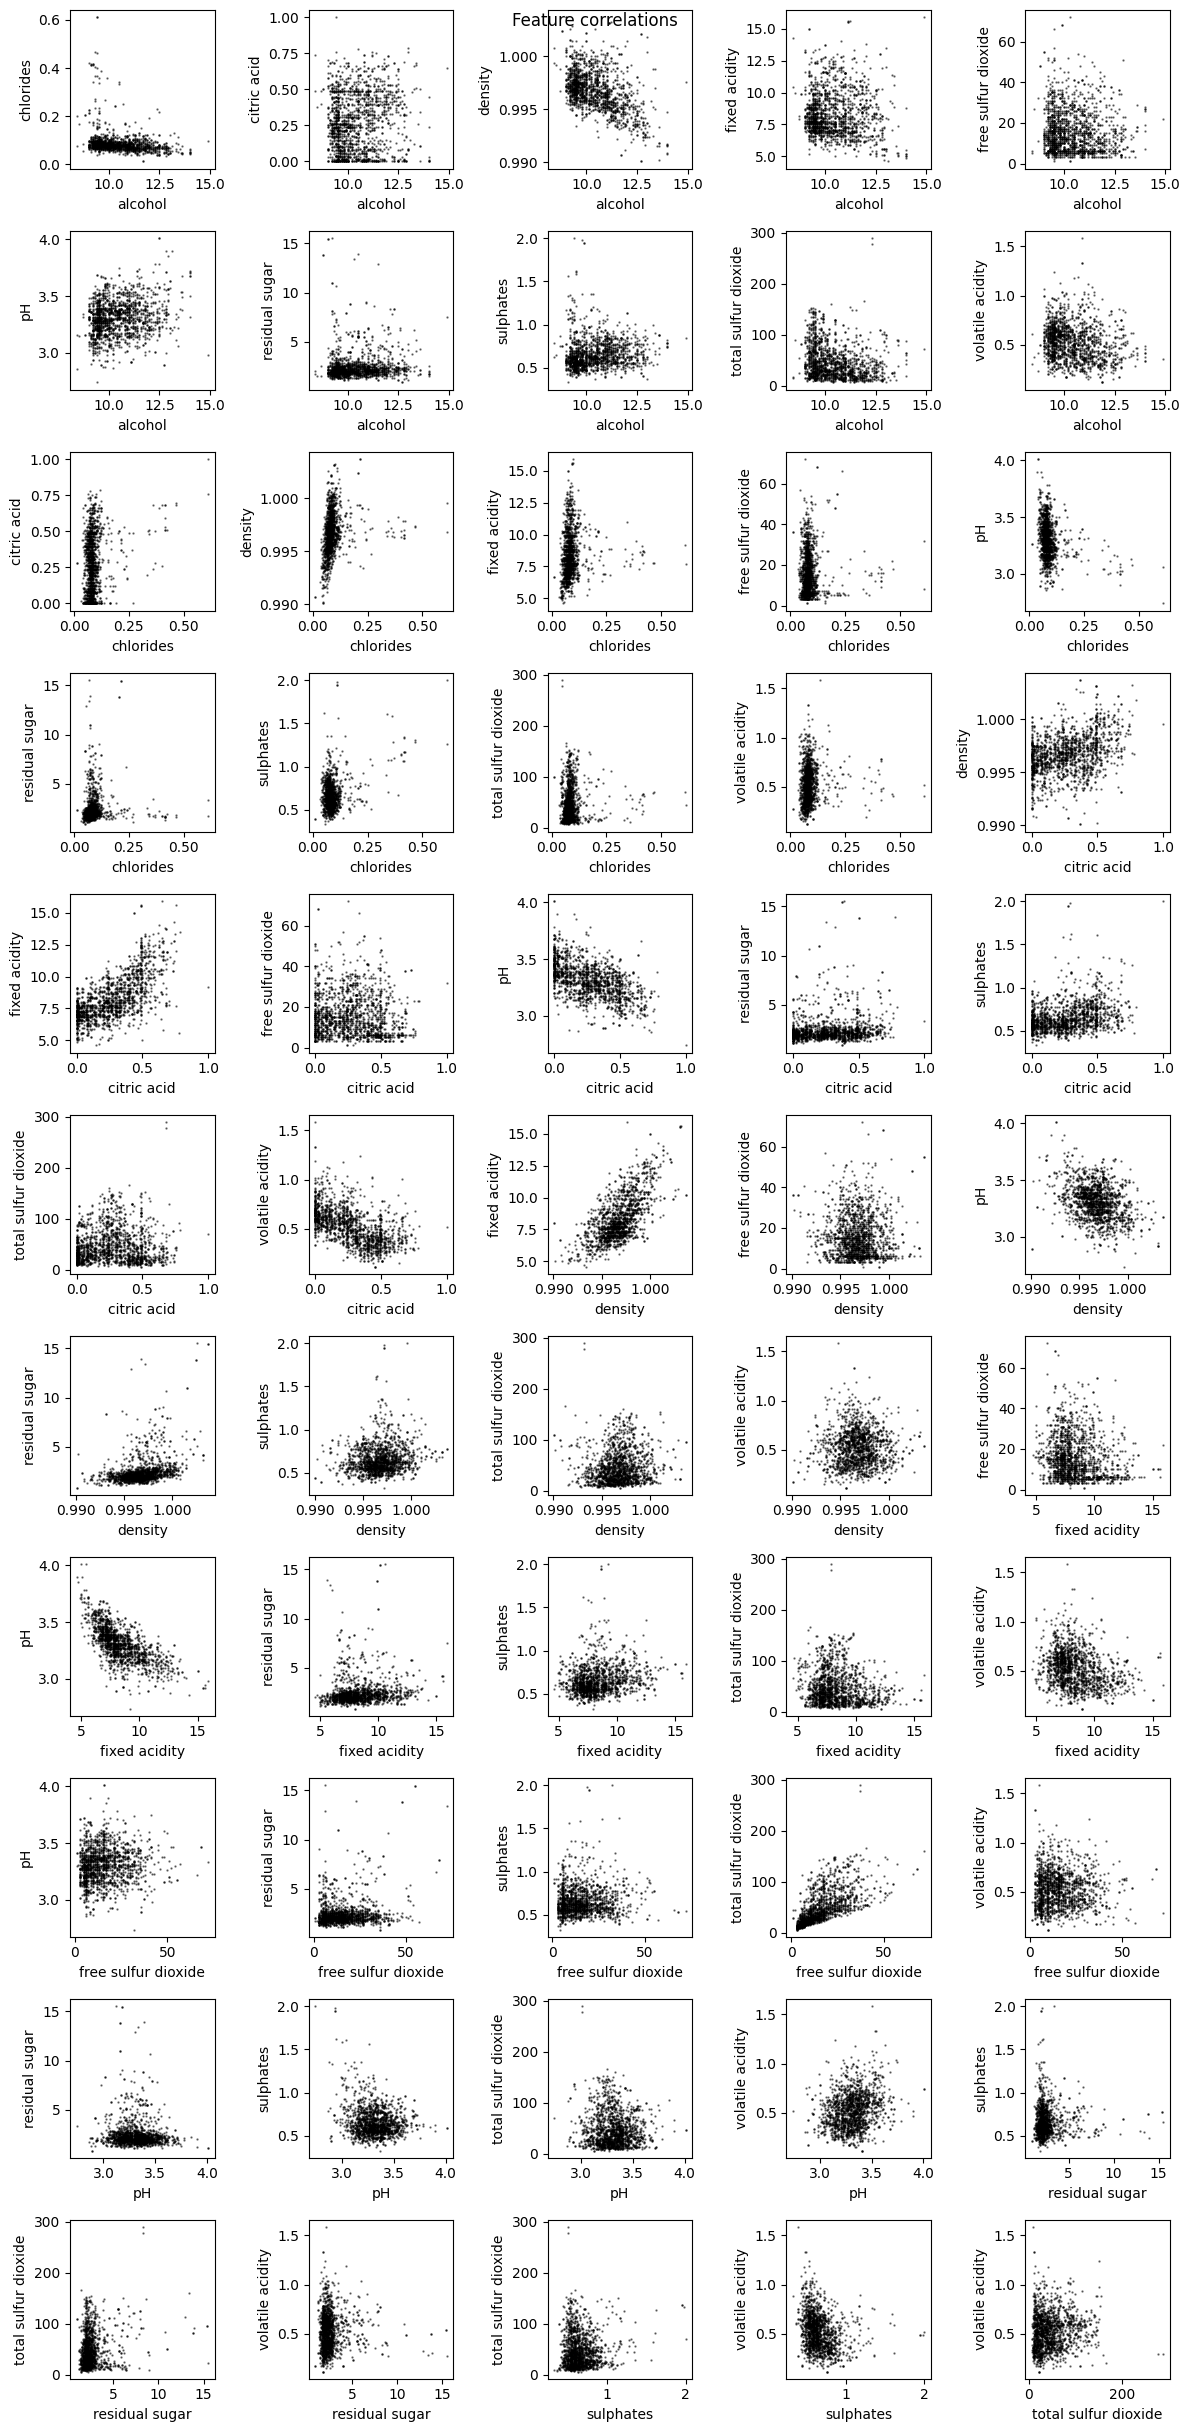

In [10]:
# Generate all possible pairs of features for correlation analysis
# combinations() creates unique pairs, sorted() ensures consistent ordering
feature_pairs = sorted(map(sorted, combinations(set(features), 2)))

# Calculate number of rows needed for subplot grid (5 columns per row)
rows = len(feature_pairs) // 5  # Integer division to get whole rows

# Create subplot grid for scatter plots (calculated rows, 5 columns)
fig, axs = plt.subplots(rows, 5, figsize=(12, rows*2.25))

# Flatten the 2D array to make indexing easier
axs = axs.flatten()

fig.suptitle('Feature correlations')

# Create scatter plot for each feature pair to visualize relationships
for i, feature_pair in enumerate(feature_pairs):
    axs[i].scatter(
        data_df[feature_pair[0]],
        data_df[feature_pair[1]],
        color='black',
        s=0.5,     # Small point size for better visualization with many points
        alpha=0.5  # Semi-transparent points to show overlapping data
    )
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

# Adjust layout to prevent overlapping labels and titles
fig.tight_layout()

#### 2.2.2. Feature-label interactions

Now let's explore how each feature relates to wine quality. The boxplots below will show the distribution of each feature across different quality levels, helping us identify which features are most discriminative for quality prediction.

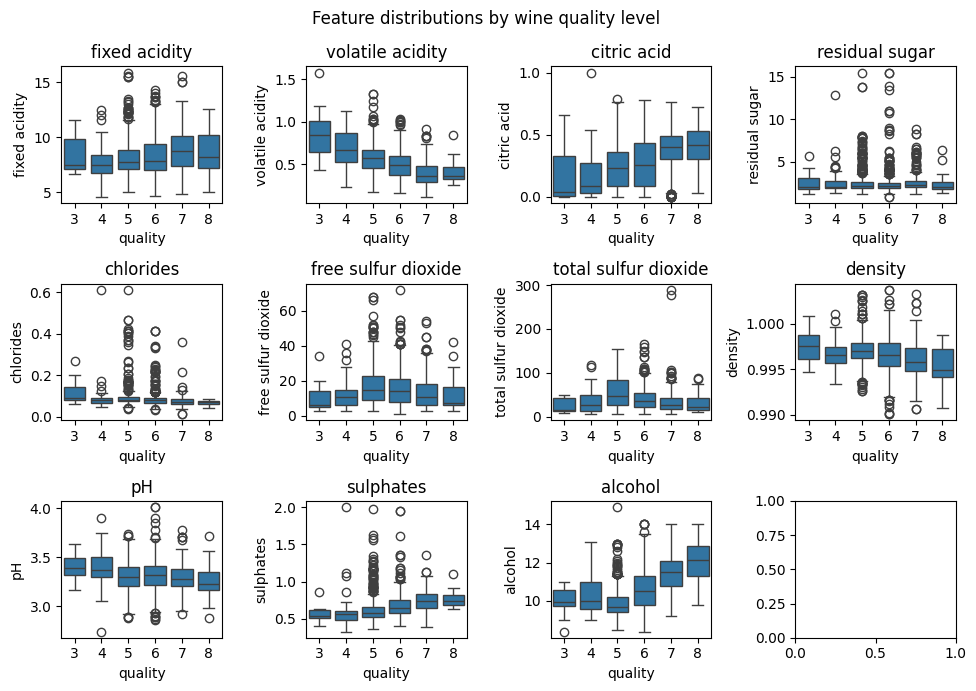

In [11]:
# Create subplot grid for boxplots (3 rows, 4 columns to accommodate 11 features)
fig, axs = plt.subplots(3,4, figsize=(10,7))

# Flatten the 2D array to make indexing easier
axs = axs.flatten()

fig.suptitle('Feature distributions by wine quality level')

# Create boxplot for each feature, grouped by quality score
for i, feature in enumerate(features):
    
    sns.boxplot(data_df, x='quality', y=feature, ax=axs[i])
    axs[i].set_title(feature)

# Adjust layout to prevent overlapping elements
fig.tight_layout()

## 3. Data preparation

### 3.1. Label binning

For this classification task, we'll convert the continuous quality scores (3-8) into discrete categories. This binning approach will simplify our problem from multi-class regression to a 3-class classification problem: low (≤4), medium (5-6), and high (≥7) quality wines.

In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [13]:
# Define function to convert continuous quality scores to discrete categories
# This simplifies our multi-class classification problem
def quality_to_label(q):
    """
    Convert quality scores (3-8) to categorical labels (0-2)
    
    Args:
        q (int): Original quality score
        
    Returns:
        int: Categorical label (0=low, 1=medium, 2=high)
    """
    if q <= 4:
        return 0  # Low quality wines (scores 3-4)
    elif q <= 6:
        return 1  # Medium quality wines (scores 5-6)
    else:
        return 2  # High quality wines (scores 7-8)

# Apply the binning function to create new categorical target variable
data_df['label'] = data_df['quality'].apply(quality_to_label)

# Remove the original continuous quality column since we now have categorical labels
data_df.drop('quality', axis=1, inplace=True)

# Verify the transformation was successful
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  label                 1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### 3.2. Train-test split

We'll split our data into training and testing sets to properly evaluate our models. Using stratified splitting ensures that the class distribution is maintained in both sets, which is important for balanced model evaluation.

In [14]:
# Split the data into training and testing sets
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.3,             # Reserve 30% for testing, 70% for training
    stratify=data_df['label']  # Maintain the same class distribution in both sets
)

### 3.3. Scaling

Feature scaling is crucial for KNN algorithms since they rely on distance calculations. StandardScaler will normalize all features to have mean=0 and std=1, ensuring that no single feature dominates the distance calculations due to scale differences.

In [15]:
# Initialize StandardScaler for feature normalization
# This transforms features to have mean=0 and standard deviation=1
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing features
# IMPORTANT: We fit only on training data to prevent data leakage
training_df[features] = scaler.fit_transform(training_df[features])

# Use the same scaler parameters for testing data (no fitting on test data)
testing_df[features] = scaler.transform(testing_df[features])

# Display the shapes of our training and testing sets
print(f'Training data: {training_df.shape}')
print(f'Testing data: {testing_df.shape}')

Training data: (1119, 12)
Testing data: (480, 12)


## 3. KNN modeling

In [16]:
# Dictionary to store cross-validation results for all models
# This will allow us to compare performance across different approaches
cross_val_scores = {
    'Model': [],  # Model names for comparison
    'Score': []   # Accuracy scores from cross-validation
}

### 3.1. Baseline logistic regression model

Before diving into KNN, let's establish a baseline performance with logistic regression. This will give us a reference point to compare our KNN models against and help us understand if the more complex KNN approach provides meaningful improvements.

In [17]:
# Create baseline logistic regression model for performance comparison
linear_model = LogisticRegression(
    max_iter=5000,              # Increase iterations to ensure convergence
    class_weight=CLASS_WEIGHT,  # Handle class imbalance by weighting classes
    random_state=RANDOM_SEED    # Ensure reproducible results across runs
)

# Perform k-fold cross-validation to get robust performance estimate
# This gives us multiple performance measurements instead of just one
scores = cross_val_score(
    linear_model,                          # Model to evaluate
    training_df.drop('label', axis=1),     # Features (all columns except target)
    training_df['label'],                  # Target variable
    cv=CROSS_VAL_FOLDS,                    # Number of cross-validation folds
    n_jobs=-1                              # Use all available CPU cores for parallel processing
)

# Store results for later comparison with KNN models
cross_val_scores['Model'].extend(['Logistic regression']*len(scores))
cross_val_scores['Score'].extend(scores*100)  # Convert to percentages

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy of logistic regression: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy of logistic regression: 59.4 +/- 4.7%


### 3.2. Naive KNN classifier

Now let's implement a naive KNN classifier using default parameters. This will serve as our starting point for KNN optimization and help us understand the baseline performance of the algorithm with no hyperparameter tuning.

In [18]:
# Create a naive KNN classifier with default parameters
# Default: n_neighbors=5, weights='uniform', algorithm='auto', metric='minkowski'
naive_model = KNeighborsClassifier()

# Perform k-fold cross-validation to evaluate performance
scores = cross_val_score(
    naive_model,                           # KNN model with default parameters
    training_df.drop('label', axis=1),     # Features (all columns except target)
    training_df['label'],                  # Target variable (wine quality categories)
    cv=CROSS_VAL_FOLDS,                    # Number of cross-validation folds
    n_jobs=-1,                             # Use all available CPU cores for parallel processing
    scoring='accuracy'                     # Use accuracy metric to be consistent with logistic regression
)

# Store results for comparison with other models
cross_val_scores['Model'].extend(['Naive KNN']*len(scores))
cross_val_scores['Score'].extend(scores*100)  # Convert to percentages

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy of naive KNN: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy of naive KNN: 82.2 +/- 2.0%


### 3.3. Optimized KNN

Now we'll optimize our KNN model through hyperparameter tuning. We'll use GridSearchCV to systematically test different combinations of parameters including the number of neighbors, weighting schemes, algorithms, and distance metrics to find the best performing configuration.

In [19]:
%%time

# Define the hyperparameter search space for KNN optimization
# We'll systematically test different combinations of these parameters
hyperparameters = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10],           # Number of neighbors to consider
    'weights': ['uniform', 'distance'],              # How to weight neighbors (equally vs by distance)
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],  # Algorithm for neighbor search
    'metric': ['minkowski', 'euclidean']             # Distance metric for calculating similarity
}

# Perform grid search over all hyperparameter combinations
# This will test every possible combination to find the best performing set
search = GridSearchCV(
    naive_model,            # Base KNN model to optimize
    hyperparameters,        # Parameter grid to search over
    cv=CROSS_VAL_FOLDS,     # Cross-validation folds for each parameter combination
    n_jobs=-1               # Use all CPU cores for parallel processing
)

# Fit the search to find the best hyperparameters
search_results = search.fit(training_df.drop('label', axis=1), training_df['label'])

# Extract the best performing model and its parameters
optimized_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')
for key, value in winning_hyperparameters.items():
    print(f' {key}: {value}')

print()
print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 algorithm: ball_tree
 metric: minkowski
 n_neighbors: 8
 weights: distance

Run time (2 CPUs):

CPU times: user 305 ms, sys: 15.1 ms, total: 320 ms
Wall time: 5.52 s


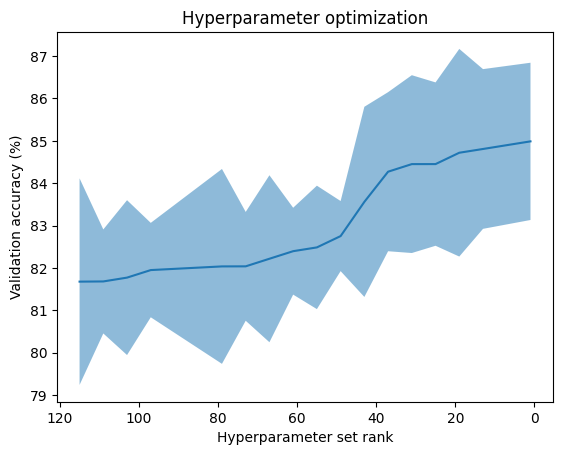

In [20]:
# Visualize the hyperparameter optimization results
funcs.plot_cross_validation(search_results)

In [21]:
# Perform cross-validation on the optimized KNN model
scores = cross_val_score(
    optimized_model,                       # KNN model with optimized hyperparameters
    training_df.drop('label', axis=1),     # Features
    training_df['label'],                  # Target variable
    cv=CROSS_VAL_FOLDS,                    # Number of cross-validation folds
    n_jobs=-1                              # Use all CPU cores for parallel processing
)

# Store results for comparison with other models
cross_val_scores['Model'].extend(['Optimized KNN']*len(scores))
cross_val_scores['Score'].extend(scores*100)  # Convert to percentages

# Display cross-validation results for the optimized model
print(f'Optimized KNN cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized KNN cross-validation accuracy: 85.0 +/- 1.9%


### 3.4. KNN + adaptive synthetic over-sampling

#### 3.4.1. Adaptive oversampling

To address potential class imbalance in our wine quality data, we'll apply ADASYN (Adaptive Synthetic Sampling) oversampling. This technique generates synthetic samples for minority classes to create a more balanced dataset, which can improve classification performance especially for underrepresented quality categories.

In [22]:
# Initialize ADASYN (Adaptive Synthetic Sampling) for handling class imbalance
# ADASYN generates synthetic samples for minority classes to balance the dataset
over_sampler = ADASYN(random_state=RANDOM_SEED)

# Apply oversampling to the training data
augmented_data = over_sampler.fit_resample(training_df[features], training_df['label'])

# Reconstruct the augmented training dataframe
augmented_training_df = augmented_data[0]
augmented_training_df['label'] = augmented_data[1]

# Display the first few rows to verify the structure
augmented_training_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label
0,-0.740737,0.396315,0.149999,1.414911,-0.430079,0.438503,1.943725,1.274580,-0.101233,3.033688,-0.234850,1
1,0.455920,-1.716406,-0.153069,-0.316402,-0.205044,-1.455647,-0.547856,1.200319,0.603961,1.238628,-0.141111,1
2,-0.854704,0.729903,-1.011762,-0.677092,-0.385072,0.039734,0.454854,-0.539515,-0.165342,-0.376925,-1.078499,1
3,-0.227884,0.729903,-1.365342,-0.821368,0.200017,-0.957187,-1.003633,-0.555428,0.732178,-0.496596,-0.891022,1
4,0.911790,-0.493252,0.958181,-0.244264,0.087500,-0.558418,-0.152849,-0.189426,-0.870536,0.161593,1.358711,1


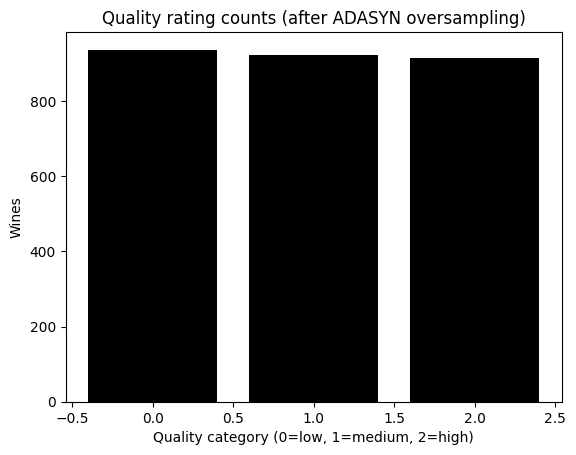

In [23]:
# Count the frequency of each quality label after ADASYN oversampling
label_counts = augmented_training_df['label'].value_counts()

# Visualize the new class distribution after oversampling
plt.title('Quality rating counts (after ADASYN oversampling)')
plt.bar(label_counts.index, label_counts.values, color='black')
plt.xlabel('Quality category (0=low, 1=medium, 2=high)')
plt.ylabel('Wines')
plt.show()

#### 3.4.1. KNN optimization

In [24]:
%%time

# Perform grid search over the same hyperparameters using the augmented dataset
search = GridSearchCV(
    naive_model,            # Base KNN model to optimize
    hyperparameters,        # Parameter grid to search
    cv=CROSS_VAL_FOLDS,     # Cross-validation folds
    n_jobs=-1               # Use all CPU cores for parallel processing
)

# Fit the search on the ADASYN-augmented training data
# This optimizes hyperparameters on the balanced dataset
search_results = search.fit(augmented_training_df.drop('label', axis=1), augmented_training_df['label'])

# Extract the best model and parameters for the ADASYN approach
adsyn_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found for the ADASYN approach
print('Best hyperparameters (with ADASYN):\n')
for key, value in winning_hyperparameters.items():
    print(f' {key}: {value}')

print()
print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters (with ADASYN):

 algorithm: ball_tree
 metric: minkowski
 n_neighbors: 1
 weights: uniform

Run time (2 CPUs):

CPU times: user 375 ms, sys: 24.2 ms, total: 399 ms
Wall time: 10.5 s


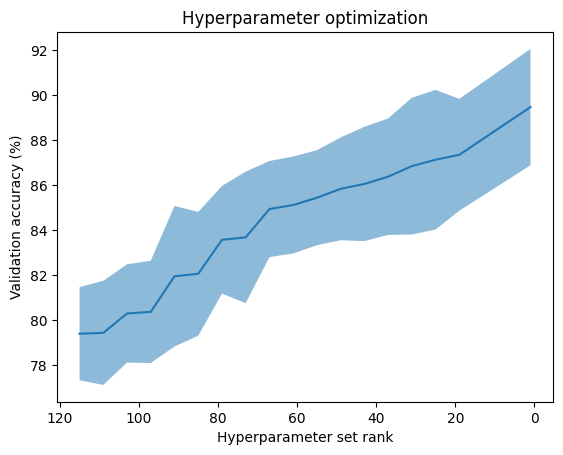

In [25]:
# Visualize the hyperparameter optimization results for ADASYN approach
funcs.plot_cross_validation(search_results)

In [26]:
# Perform cross-validation on the ADASYN-optimized KNN model
scores = cross_val_score(
    adsyn_model,                                    # KNN model optimized on ADASYN data
    augmented_training_df.drop('label', axis=1),    # Augmented features (includes synthetic samples)
    augmented_training_df['label'],                 # Augmented labels (balanced classes)
    cv=CROSS_VAL_FOLDS,                             # Number of cross-validation folds
    n_jobs=-1                                       # Use all CPU cores for parallel processing
)

# Store results for comparison with other approaches
cross_val_scores['Model'].extend(['KNN + ADASYN']*len(scores))
cross_val_scores['Score'].extend(scores*100)  # Convert to percentages

# Display cross-validation results for the ADASYN approach
print(f'Optimized KNN + ADASYN cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Optimized KNN + ADASYN cross-validation accuracy: 89.5 +/- 2.6%


## 4. Model comparison

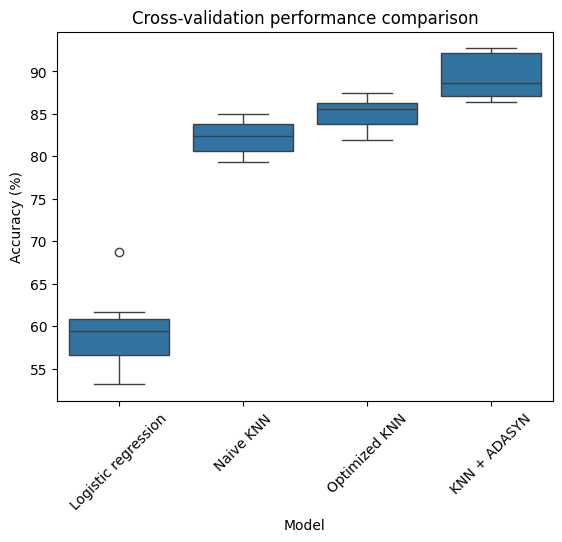

In [27]:
# Create boxplot to compare cross-validation performance across all models
sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.show()

## 5. Model evaluation

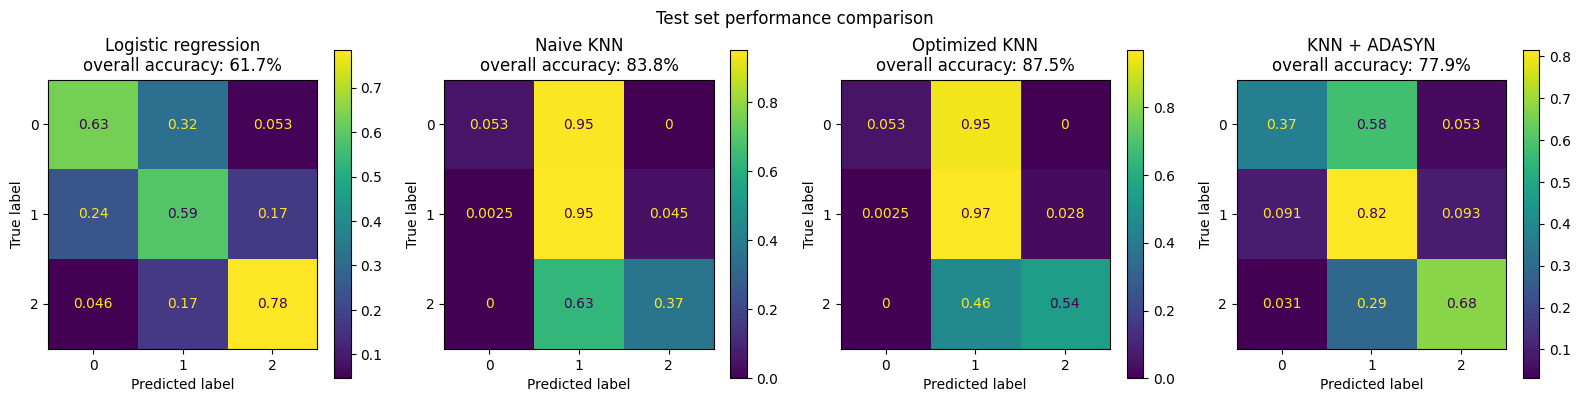

In [28]:
# Retrain all models on their respective full training sets
# This prepares them for final evaluation on the unseen test set

# Train logistic regression on original training data
result = linear_model.fit(training_df.drop('label', axis=1), training_df['label'])

# Train naive KNN on original training data  
result = naive_model.fit(training_df.drop('label', axis=1), training_df['label'])

# Train optimized KNN on original training data
result = optimized_model.fit(training_df.drop('label', axis=1), training_df['label'])

# Train ADASYN-optimized KNN on the augmented (oversampled) training data
result = adsyn_model.fit(augmented_training_df.drop('label', axis=1), augmented_training_df['label'])

# Generate confusion matrices for all models on the test set
# This provides detailed performance analysis including per-class accuracy
funcs.plot_confusion_matrices(
    models = {
        'Logistic regression': linear_model,    # Baseline linear model
        'Naive KNN': naive_model,              # KNN with default parameters
        'Optimized KNN': optimized_model,      # KNN with tuned hyperparameters
        'KNN + ADASYN': adsyn_model           # KNN with hyperparameter tuning + oversampling
    },
    testing_df=testing_df,  # Original test set (not augmented)
    label='label'           # Target column name
)